In [1]:
# initialization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
import re
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

from sklearn.metrics import accuracy_score

nltk.download('punkt')
nltk.download('stopwords')

np.random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cheryl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cheryl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data

In [2]:
%%script false --no-raise-error # comment this if you dont have the dev_set

# import dataset
train_set = pd.read_csv('train.csv')

test_set = pd.read_csv('test.csv')

# from train_set sample development set
dev_set = train_set.sample(n=500, replace=False)

# remove dev set from train set
train_set = train_set.drop(dev_set.index)

# check
print(train_set.shape, dev_set.shape, test_set.shape)

# save to dataframe
dev_set.to_csv("dev_set.csv", index=False)
train_set.to_csv("train_set_modified.csv", index=False)

Couldn't find program: 'false'


In [60]:
train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

## Preprocess data (averaging over word representations)

TODO: Try max pooling

TODO: Take representation of last word in LSTM

TODO: Use attention and perform weighted average?



In [4]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

In [61]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [62]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    if (len(filtered_sentence) == 0):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [63]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [64]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
average_word_embeddings = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # perform averaging of word embeddings
    awe = np.mean(word_embeddings, axis = 0)
    average_word_embeddings.append(awe)

train_set['vector'] = average_word_embeddings

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[-0.013671875, -0.05543518, 0.05633545, 0.2869..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[-0.00927734375, 0.07685546875, -0.05764770507..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[0.029272461, 0.13002929, -0.021777343, 0.1398..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[0.06305949, 0.03805542, -0.08516184, 0.015625..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[-0.036621094, -0.007965088, -0.08154297, 0.04..."


In [65]:
def aggregate_representations(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  average_word_embeddings = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # perform averaging of word embeddings
      awe = np.mean(word_embeddings, axis = 0)

      average_word_embeddings.append(awe)


  dataset['vector'] = average_word_embeddings
  display(dataset[dataset['vector'].isna()])

  dataset = pd.concat([dataset, dataset['vector'].apply(lambda x: pd.Series(x))], axis=1)

  return dataset

dev_set = aggregate_representations(dev_set)
train_set = aggregate_representations(train_set)

# train_set

,label-coarse,label-fine,text,cleaned_text,vector


,label-coarse,label-fine,text,cleaned_text,vector


In [66]:
dev_set

,label-coarse,label-fine,text,cleaned_text,vector,0,1,2,3,4,...,290,291,292,293,294,295,296,297,298,299
0,4,40,How long is the border between Canada and the ...,"[long, border, canada, conterminous, states]","[-0.113293454, -0.009765625, -0.0690918, 0.169...",-0.113293,-0.009766,-0.069092,0.169824,0.053711,...,0.004858,0.052246,0.044312,0.129883,0.144141,0.057983,-0.052539,0.047949,0.065816,-0.058594
1,4,8,When was Yemen reunified ?,"[yemen, reunified]","[-0.006225586, 0.004638672, 0.046207428, 0.208...",-0.006226,0.004639,0.046207,0.208740,-0.185303,...,-0.230957,0.218872,0.038849,0.020264,-0.062500,0.055603,-0.251221,-0.169189,0.091064,-0.015137
2,1,14,What 's destroyed in Genesis 19 : 24 ?,"[destroyed, genesis]","[0.17041016, 0.036376953, 0.057006836, 0.05187...",0.170410,0.036377,0.057007,0.051880,0.006104,...,-0.182861,0.016815,-0.194336,0.028687,-0.046021,-0.171387,-0.155762,-0.131104,-0.009399,-0.094208
3,3,4,Who was Israel 's first prime minister ?,"[israel, first, prime, minister]","[-0.049316406, -0.029067993, 0.046905518, 0.09...",-0.049316,-0.029068,0.046906,0.090454,-0.099121,...,-0.097656,0.064270,-0.067230,-0.083191,-0.036133,-0.052551,-0.110550,-0.174133,0.017700,0.117798
4,1,33,Musician Ray Charles plays what instrument ?,"[musician, ray, charles, plays, instrument]","[0.08581543, -0.023937989, 0.05341797, 0.04287...",0.085815,-0.023938,0.053418,0.042871,-0.065698,...,-0.040344,0.002344,-0.063281,-0.071680,-0.069983,0.009570,-0.080518,0.042627,-0.003467,0.054102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3,12,Who is Shirley MacLaine ?,"[shirley, maclaine]","[-0.033447265625, 0.0213623046875, -0.00114440...",-0.033447,0.021362,-0.001144,0.017578,0.002747,...,0.081055,0.119629,0.049072,0.070312,-0.111328,-0.113281,-0.029541,-0.062988,-0.070801,0.010986
496,1,26,What are different products of petroleum ?,"[different, products, petroleum]","[-0.069498695, 0.09472656, -0.04683431, 0.1261...",-0.069499,0.094727,-0.046834,0.126139,-0.033203,...,-0.102214,-0.056315,-0.049398,0.039958,0.010579,0.083862,0.224609,0.054077,0.049479,-0.003906
497,1,14,What did Jack exchange with the butcher for a ...,"[jack, exchange, butcher, handful, beans]","[-0.111523435, 0.09986572, -0.09863281, 0.1219...",-0.111523,0.099866,-0.098633,0.121945,0.060645,...,0.046492,-0.021387,-0.061206,0.038818,0.037549,0.022754,0.033472,-0.043994,0.008154,0.162402
498,3,4,"Who is the author of the book , `` The Iron La...","[author, book, iron, lady, biography, margaret...","[0.0925293, 0.010672433, 0.0033580235, 0.04336...",0.092529,0.010672,0.003358,0.043361,0.057341,...,0.029314,0.001408,-0.138410,-0.134609,-0.091204,-0.145944,-0.008745,0.018051,0.015259,0.086421


### Prepare data for training

In [67]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df
  # print(df['encoded_coarse_label'])

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)

In [68]:
# split into X and y
X_train = train_set.drop(columns=['label-coarse', 'label-fine', 'text', 'cleaned_text', 'vector', 'encoded-coarse-label']).to_numpy()
y_train = train_set['encoded-coarse-label']

X_dev = dev_set.drop(columns=['label-coarse', 'label-fine', 'text', 'cleaned_text', 'vector', 'encoded-coarse-label']).to_numpy()
y_dev = dev_set['encoded-coarse-label']

# without one hot
# X_train = train_set.drop(columns=['label-coarse', 'label-fine', 'text', 'cleaned_text', 'vector']).to_numpy()
# y_train = train_set['label-coarse']

# X_dev = dev_set.drop(columns=['label-coarse', 'label-fine', 'text', 'cleaned_text', 'vector']).to_numpy()
# y_dev = dev_set['label-coarse']

# SCALING?

# mini-batch strategy
batch_size = 32

# def collate_fn(data):
#     x, y = data
#     zipped = zip(x, y)
#     return list(zipped)

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

##  LSTM model

In [69]:

HIDDEN_SIZE = 128
OUTPUT_SIZE = 5
NUM_LAYERS = 1


class simple_lstm(nn.Module):
    def __init__(
                    self, 
                    input_size= 300, 
                    hidden_size= HIDDEN_SIZE, 
                    output_size= OUTPUT_SIZE,
                    num_layers= NUM_LAYERS,
                   # dropout_rate= 0.2, 
                    bidirectional= True, 
                ):
        
        super().__init__()
        # Model body
        self.lstm = nn.LSTM(input_size= input_size, hidden_size= hidden_size, bidirectional= bidirectional, num_layers= num_layers, batch_first= True)
        
        # Model head
        self.head = nn.Sequential(
            nn.Linear((2 if bidirectional else 1) * hidden_size, output_size),
           # nn.Dropout(dropout_rate),
            nn.Softmax(dim= 2)
        )
    
    def __call__(self, input):

        return self.head(self.lstm(input)[0])

In [72]:
# fed into the softmax classifier to predict the final label
class LSTMModel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_d, output_d):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_d
        self.layer_dim = layer_d

        # LSTM model
        # self.lstm = nn.LSTM(input_d, hidden_d, layer_d, batch_first=True)

        self.lstm = nn.LSTM(input_d, hidden_d, layer_d)

        self.head = nn.Sequential(
            nn.Linear(hidden_d, output_d),
            nn.Softmax(dim = 1) # softmax activation for label prediction
        )
        
    def forward(self, x, require_grad = True):
        '''
        lstm(input,(h_0, c_0)): shape for each param
        input = (batch_size, seq_len, features) (with batch_first = True)
        h_0 = (D * num_layers, batch_size, project_size or hidden size)
        c_0 = (D * num_layers, batch_size, project_size or hidden size)
        D = 2 if is bidirectional
        '''

        # 3D TENSOR
        # x = x.reshape(x.shape[0], 1, 300).float() # convert to 3D tensor

        # if require_grad:
        #   h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        #   c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # else:
        #   h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, requires_grad=False)
        #   c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, requires_grad=False)

        x = x.float()

        # 2D TENSOR
        if require_grad:
          h0 = torch.zeros(self.layer_dim, self.hidden_dim).requires_grad_()
          c0 = torch.zeros(self.layer_dim, self.hidden_dim).requires_grad_()
        else:
          h0 = torch.zeros(self.layer_dim, self.hidden_dim, requires_grad=False)
          c0 = torch.zeros(self.layer_dim, self.hidden_dim, requires_grad=False)


        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.head(out)
        
        return out

input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300

model = simple_lstm(input_dim, 128, 5, 1)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [73]:
# REFERENCE
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
train_accuracy_list = []

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0

  for x_batch, y_batch in train_loader:
    x_batch = x_batch.unsqueeze(1).float() # convert to 3D tensor
    outputs = model(x_batch) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    # print(outputs.squeeze(1).shape)
    # print(y_batch.shape)
    loss = criterion(outputs.squeeze(1), y_batch)
    if torch.isnan(loss):
       print("1")

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

  average_loss = total_training_loss / len(train_loader)
  print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs
      x_batch = x_batch.unsqueeze(1).float()

      # forward pass
      y_pred = model(x_batch)
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      print(y_pred.shape)

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      print("1", predicted_labels)

      y_batch = torch.argmax(y_batch, dim=1)

      print(y_batch)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))

  def calculate_accuracy(y_true, y_pred):
      y_true = y_true.detach().cpu().numpy()
      y_pred = y_pred.detach().cpu().numpy()
      return accuracy_score(y_true, y_pred)

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  train_accuracy_list.append(accuracy)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  else:
    current_patience += 1
    if current_patience >= max_patience:
        print(f"Early stopping after {epoch} epochs.")
        break


Epoch: 0, training set loss: 1.49231
torch.Size([32, 1, 5])
1 tensor([4, 0, 4, 0, 4, 0, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4,
        0, 4, 3, 0, 0, 4, 3, 4])
tensor([4, 1, 4, 1, 1, 0, 0, 3, 3, 4, 4, 3, 3, 4, 3, 1, 4, 4, 3, 4, 0, 4, 3, 3,
        0, 1, 1, 4, 4, 4, 3, 3])
torch.Size([32, 1, 5])
1 tensor([1, 4, 4, 1, 4, 0, 3, 0, 4, 3, 3, 4, 3, 4, 4, 3, 0, 3, 3, 4, 3, 3, 3, 0,
        4, 3, 0, 4, 4, 4, 0, 4])
tensor([1, 0, 1, 1, 0, 0, 4, 2, 1, 3, 1, 0, 0, 4, 4, 3, 1, 0, 3, 3, 0, 3, 3, 0,
        4, 3, 0, 4, 4, 1, 0, 4])
torch.Size([32, 1, 5])
1 tensor([0, 1, 0, 3, 3, 1, 0, 4, 3, 3, 3, 4, 3, 3, 1, 4, 4, 4, 4, 3, 3, 3, 3, 3,
        0, 3, 0, 0, 0, 0, 4, 3])
tensor([1, 3, 4, 1, 3, 0, 0, 4, 1, 1, 4, 0, 1, 1, 1, 4, 0, 4, 0, 3, 3, 4, 1, 4,
        0, 4, 1, 0, 1, 4, 4, 3])
torch.Size([32, 1, 5])
1 tensor([4, 4, 0, 0, 3, 0, 3, 3, 3, 3, 4, 3, 3, 0, 4, 3, 4, 3, 0, 3, 0, 4, 1, 0,
        4, 0, 4, 3, 4, 0, 4, 0])
tensor([4, 4, 4, 2, 1, 1, 3, 1, 0, 3, 1, 1, 3, 0, 4, 0, 1, 0, 0, 3, 1, 4

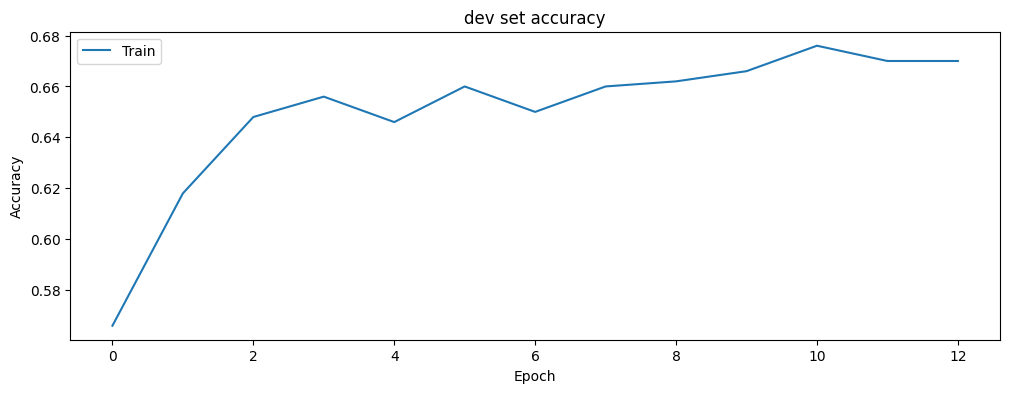

In [74]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('dev set accuracy')
plt.plot(range(len(train_accuracy_list)), train_accuracy_list, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

- aggregation: max pooling, last word
- number of layers
- hidden dimensions
- learning rate
- mini-batch size